# High school network and deep learning

Our point is, considering the positive and negative networks as two different directed graphs, use a GConv network with previous autoencoder (Tutorial 12 Pytorch Geometric) to predict links from one of the networks, then compare the predicted_edges with the negative ones. Consider the positive as the training set and compare it to the negatives in the test one. 

* We are going to use a graph autoencoder, which is a non-supervised neural network that takes data, translate them to another representation (the one the neural network extracts from them) and then try to rebuild the original data. The representation it learns is based on the structure of the network.

* We will use also a heuristic method, called PageRank method, traditionally used in link prediction, where the probability of a link depends on a variable called rank. 

* We compare it with a null method, a random graph. 

In both of the comparative methods of the GNN, negative links can only be placed where there are not positive links. 

The graph autoencoder generate a fixed number of links depending on built-in functions, so we are taking these number of links in order to establish comparison with other methods.

<div class="alert alert-success" role="alert">
  In this variation we are going to remove a whole class and let the neural network rebuild it. We are considering classes as main components of the whole. This is done just in the positive network. 
</div>

In [1]:
import numpy as np
import pandas as pd 


import torch
import torch_geometric.data as data
from torch_geometric.nn import GCNConv
import torch_geometric.transforms as T
import torch.nn.functional as F
from torch_geometric.utils import negative_sampling,train_test_split_edges,to_dense_adj
from sklearn.metrics import roc_auc_score
from torch_geometric.transforms import RandomLinkSplit
from sklearn import preprocessing

device = "cpu"

In [2]:
import networkx as nx
## Just prepare the data
nodes = pd.read_csv(r"Nodes_t1.csv",sep=";",encoding = 'unicode_escape')
edges = pd.read_csv(r"Edges_t1.csv",sep=";",encoding = 'unicode_escape')
edges = edges.apply(lambda x: x - x.min(),axis = 0)
###Erase ESO 
nodes["Curso"] = nodes["Curso"].astype(str).str[0].astype("int64")
del nodes["Unnamed: 0"]
edges["weight"] = edges["weight"].apply(lambda x:x+1)
pos_edges = edges[edges["weight"]> 3]
neg_edges = edges[edges["weight"]< 3]
G_positive = nx.from_pandas_edgelist(pos_edges, "from", "to",create_using=nx.DiGraph,edge_attr="weight")
G_negative = nx.from_pandas_edgelist(neg_edges, "from", "to",create_using=nx.DiGraph,edge_attr="weight")
G_negative.add_nodes_from(range(nodes.index.max()+1))

<div class="alert alert-success" role="alert">
    We need to remove from the data the edges of a whole class and label them as <i> y_true</i>.
    We remove the edges that come from a target course, such that the intraclass links are removed and also the 
    links that have source in class. 
</div

In [3]:
curso = 2 
grupo = "C"

nodes_class = list(nodes[(nodes["Curso"] == curso)&(nodes["Grupo"] == grupo)].index)
edges_class = edges[(edges["from"].isin(nodes_class))]
edges_class_saved = torch.Tensor([edges_class["from"].to_numpy(),edges_class["to"].to_numpy()])
edges_class_saved = edges_class_saved.type(torch.LongTensor)
edges.drop(edges_class.index,inplace = True)


/tmp/ipykernel_39293/2115103283.py:6: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  edges_class_saved = torch.Tensor([edges_class["from"].to_numpy(),edges_class["to"].to_numpy()])


## Graph autoencoders

### Load the dataset

In [4]:
nodes = pd.read_csv(r"Nodes_t1.csv",sep=";",encoding = 'unicode_escape')
edges = pd.read_csv(r"Edges_t1.csv",sep=";",encoding = 'unicode_escape')
edges = edges.apply(lambda x: x - x.min(),axis = 0)
###Erase ESO 
nodes["Curso"] = nodes["Curso"].astype(str).str[0].astype("int64")
del nodes["Unnamed: 0"]
### Separate positive from negative networks
pos_edges = edges[edges["weight"]> 2]
neg_edges = edges[edges["weight"]< 2] 
### One hot encode and normalize node attributes
nodes_dummy = pd.get_dummies(nodes[["Curso","Grupo"]])
rng = np.random.default_rng()
#nodes_dummy = pd.DataFrame(rng.integers(0, 2, size=(409, 10)), columns=list('ABCDEFGHIJ'))

x = nodes_dummy.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
nodes_norm = pd.DataFrame(x_scaled)

### Firstly, check for isomorphism with Networkx 

Networkx has a isomorphism library that comes mainly from the VF2 algorithm : https://www.researchgate.net/publication/200034365_An_Improved_Algorithm_for_Matching_Large_Graphs


In [5]:
from networkx.algorithms import isomorphism


DiGM = isomorphism.DiGraphMatcher(G_positive,G_negative)

print("The graph of positive links is direcly isomorphic to the negative one ? {}.".format(DiGM.is_isomorphic()))

The graph of positive links is direcly isomorphic to the negative one ? False.


In [1]:
nodes_norm

NameError: name 'nodes_norm' is not defined

In [6]:
###Without including class and group information 
positive_data = data.Data(x=torch.tensor(nodes_norm.to_numpy(),dtype=torch.float32),
                          edge_index=torch.tensor(pos_edges[["from","to"]].to_numpy().T))
negative_data = data.Data(x=torch.tensor(nodes_norm.to_numpy(),dtype=torch.float32),
                          edge_index=torch.tensor(neg_edges[["from","to"]].to_numpy().T))

In [7]:
data = positive_data.clone()
data.num_nodes = len(data._store["x"])
data = train_test_split_edges(data)


/home/juan/.local/lib/python3.8/site-packages/torch_geometric/deprecation.py:13: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


### Models for the neural network

#### Autoencoder

In [8]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(data.num_features, 128)
        self.conv2 = GCNConv(128, 64)

    def encode(self):
        x = self.conv1(data.x, data.train_pos_edge_index) # convolution 1
        x = x.relu()
        return self.conv2(x, data.train_pos_edge_index) # convolution 2

    def decode(self, z, pos_edge_index, neg_edge_index): # only pos and neg edges
        edge_index = torch.cat([pos_edge_index, neg_edge_index], dim=-1) # concatenate pos and neg edges
        logits = (z[edge_index[0]] * z[edge_index[1]]).sum(dim=-1)  # dot product 
        return logits

    def decode_all(self, z): 
        prob_adj = z @ z.t() # get adj NxN
        return (prob_adj > 1-10e-10).nonzero(as_tuple=False).t() # get predicted edge_list 

#### Set the parameters and move data to autoencoder

In [9]:
model, positive_data = Net().to(device), positive_data.to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)

#### Algorithms of training and evaluation (Tutorial PyG)

In [10]:

def get_link_labels(pos_edge_index, neg_edge_index):
    # returns a tensor:
    # [1,1,1,1,...,0,0,0,0,0,..] with the number of ones is equel to the lenght of pos_edge_index
    # and the number of zeros is equal to the length of neg_edge_index
    E = pos_edge_index.size(1) + neg_edge_index.size(1)
    link_labels = torch.zeros(E, dtype=torch.float, device=device)
    link_labels[:pos_edge_index.size(1)] = 1.
    return link_labels


def train():
    model.train()

    neg_edge_index = negative_sampling(
        edge_index=data.train_pos_edge_index, #positive edges
        num_nodes=data.num_nodes, # number of nodes
        num_neg_samples=data.train_pos_edge_index.size(1)) # number of neg_sample equal to number of pos_edges

    optimizer.zero_grad()
    
    z = model.encode() #encode
    link_logits = model.decode(z, data.train_pos_edge_index, neg_edge_index) # decode
    
    link_labels = get_link_labels(data.train_pos_edge_index, neg_edge_index)
    loss = F.binary_cross_entropy_with_logits(link_logits, link_labels)
    loss.backward()
    optimizer.step()

    return loss


@torch.no_grad()
def test():
    model.eval()
    perfs = []
    for prefix in ["val", "test"]:
        pos_edge_index = data[f'{prefix}_pos_edge_index']
        neg_edge_index = data[f'{prefix}_neg_edge_index']

        z = model.encode() # encode train
        link_logits = model.decode(z, pos_edge_index, neg_edge_index) # decode test or val
        link_probs = link_logits.sigmoid() # apply sigmoid
        
        link_labels = get_link_labels(pos_edge_index, neg_edge_index) # get link
        
        perfs.append(roc_auc_score(link_labels.cpu(), link_probs.cpu())) #compute roc_auc score
    return perfs


#### Training and test

In [11]:
best_val_perf = test_perf = 0
for epoch in range(1, 2001):
    train_loss = train()
    val_perf, tmp_test_perf = test()
    if val_perf > best_val_perf:
        best_val_perf = val_perf
        test_perf = tmp_test_perf
    log = 'Epoch: {:03d}, Loss: {:.4f}, Val: {:.4f}, Test: {:.4f}'
    if epoch % 100 == 0:
        print(log.format(epoch, train_loss, best_val_perf, test_perf))

Epoch: 100, Loss: 0.4548, Val: 0.8914, Test: 0.9060
Epoch: 200, Loss: 0.4323, Val: 0.9070, Test: 0.9133
Epoch: 300, Loss: 0.4309, Val: 0.9113, Test: 0.9130
Epoch: 400, Loss: 0.4204, Val: 0.9154, Test: 0.9147
Epoch: 500, Loss: 0.4218, Val: 0.9163, Test: 0.9188
Epoch: 600, Loss: 0.4164, Val: 0.9185, Test: 0.9258
Epoch: 700, Loss: 0.4218, Val: 0.9195, Test: 0.9238
Epoch: 800, Loss: 0.4159, Val: 0.9204, Test: 0.9272
Epoch: 900, Loss: 0.4145, Val: 0.9209, Test: 0.9293
Epoch: 1000, Loss: 0.4094, Val: 0.9213, Test: 0.9265
Epoch: 1100, Loss: 0.4114, Val: 0.9225, Test: 0.9296
Epoch: 1200, Loss: 0.4039, Val: 0.9225, Test: 0.9296
Epoch: 1300, Loss: 0.4064, Val: 0.9225, Test: 0.9296
Epoch: 1400, Loss: 0.4096, Val: 0.9225, Test: 0.9296
Epoch: 1500, Loss: 0.4019, Val: 0.9228, Test: 0.9284
Epoch: 1600, Loss: 0.4139, Val: 0.9237, Test: 0.9313
Epoch: 1700, Loss: 0.3963, Val: 0.9243, Test: 0.9289
Epoch: 1800, Loss: 0.3997, Val: 0.9248, Test: 0.9347
Epoch: 1900, Loss: 0.4063, Val: 0.9248, Test: 0.9347
Ep

<div class = "alert alert-success">
    We will produce the links, and from them extract the ones referred to the particular course we are trying to rebuild. 
</div>

In [12]:
z = model.encode()
final_edge_index_1 = model.decode_all(z)
#Remove self loops
bool_mask = final_edge_index_1[0] != final_edge_index_1[1]
simulated_edges_1 = torch.empty((2,int(sum(bool_mask))))
for item in range(final_edge_index_1.size()[0]):
    simulated_edges_1[item] = final_edge_index_1[item][bool_mask]
    


In [13]:
edges_saved_compare = list(zip(*edges_class_saved))
edges_saved_compare = set(list(map(lambda item: (int(item[0]),int(item[1])),edges_saved_compare)))

simulated_edges_compare = list(zip(*simulated_edges_1))
simulated_edges_compare = set(list(map(lambda item: (int(item[0]),int(item[1])),simulated_edges_compare)))

In [14]:
precision = round(len(edges_saved_compare.intersection(simulated_edges_compare))/len(edges_class_saved[0]),2)
print("The amount of links that were in the data is the {} of the total".format(precision))

The amount of links that were in the data is the 0.78 of the total


<div class = "alert alert-success">
   Compute the coincidences. To do this, we check if each of the predicted links was in the original data. 
</div>

In [15]:
n_links = 0
for item in simulated_edges_compare: 
    if item[0] in nodes_class: 
        n_links += 1
n_links

1093

In [16]:
print(f"We generated {len(simulated_edges_compare)} links, {n_links} of them are in the cut region ")
print(f"We cut a total of {len(edges_saved_compare)} links")
print(f"From {n_links}, {int(precision*len(edges_saved_compare))} of {len(edges_saved_compare)} were found in the simulated links. ")

We generated 22578 links, 1093 of them are in the cut region 
We cut a total of 385 links
From 1093, 300 of 385 were found in the simulated links. 


In [26]:

preds = nx.preferential_attachment(G_positive)

NetworkXNotImplemented: not implemented for directed type

In [23]:
for u, v, p in preds:
    print(f"({u}, {v}) -> {p}")

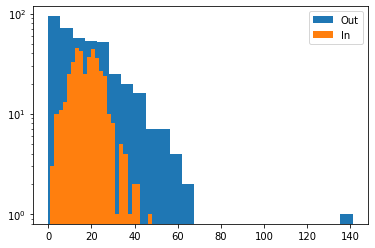

In [59]:
import matplotlib.pyplot as plt 

plt.hist([item[1] for item in G_positive.out_degree()],bins=25,label = "Out",log=True)
plt.hist([item[1] for item in G_positive.in_degree()],bins=25,label = "In",log=True)
plt.legend()
plt.savefig("test.jpg")

In [54]:
generated_links = 0
G_positive_2 = G_positive.copy()
while generated_links < n_links:
    total_degree = sum([item[1] for item in G_positive.out_degree()])
    dict_degree = dict(G_positive.out_degree())
    rd_node = rd.choice(nodes_class)
    if rd.uniform(0,1)<dict_degree[rd_node]/total_degree:
        G_positive_2.add_edge(rd_node,)

20

In [58]:
list(G_positive.out_degree())

[(0, 3),
 (21, 15),
 (32, 11),
 (94, 17),
 (1, 20),
 (2, 38),
 (3, 15),
 (4, 17),
 (5, 19),
 (6, 19),
 (7, 19),
 (8, 10),
 (10, 0),
 (11, 0),
 (12, 32),
 (13, 19),
 (14, 8),
 (15, 23),
 (16, 7),
 (27, 29),
 (30, 37),
 (31, 27),
 (33, 7),
 (68, 29),
 (79, 25),
 (17, 11),
 (18, 0),
 (26, 14),
 (36, 15),
 (43, 0),
 (52, 11),
 (53, 17),
 (54, 10),
 (61, 14),
 (63, 20),
 (64, 38),
 (72, 28),
 (77, 23),
 (84, 12),
 (91, 1),
 (112, 18),
 (126, 27),
 (128, 0),
 (131, 16),
 (9, 5),
 (66, 37),
 (85, 17),
 (73, 50),
 (19, 10),
 (20, 21),
 (24, 28),
 (93, 18),
 (145, 37),
 (159, 11),
 (168, 32),
 (22, 14),
 (37, 5),
 (86, 8),
 (25, 9),
 (29, 10),
 (56, 19),
 (120, 6),
 (28, 20),
 (213, 0),
 (336, 17),
 (137, 13),
 (58, 19),
 (23, 15),
 (46, 22),
 (142, 5),
 (149, 27),
 (166, 25),
 (186, 37),
 (189, 6),
 (193, 7),
 (216, 0),
 (283, 57),
 (286, 27),
 (301, 8),
 (302, 30),
 (307, 4),
 (308, 7),
 (119, 26),
 (147, 39),
 (197, 49),
 (214, 20),
 (218, 40),
 (220, 43),
 (294, 22),
 (333, 62),
 (354, 24),